In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the files
dim_date = pd.read_csv('dim_date.csv')
dim_districts = pd.read_csv('dim_districts.csv')
fact_stamps = pd.read_csv('fact_stamps.csv')
fact_transport = pd.read_csv('fact_transport.csv')
fact_ipass = pd.read_csv('fact_TS_iPASS.csv')

# Stamp Registration

1. How does the revenue generated from document registration vary across districts in Telangana? List down the top 5 districts that showed the highest document registration revenue growth between FY 2019 and 2022.


2. How does the revenue generated from document registration compare to the revenue generated from e-stamp challans across districts? List down the top 5 districts where e-stamps revenue contributes significantly more to the revenue than the documents in FY 2022?


3. Is there any alteration of e-Stamp challan count and document registration count pattern since the implementation of e-Stamp challan? If so, what suggestions would you propose to the government?


4. Categorize districts into three segments based on their stamp registration revenue generation during the fiscal year 2021 to 2022.

In [3]:
# Joining fact_stamps with dim_date to get fiscal_year
fact_with_date = fact_stamps.merge(dim_date[['month', 'fiscal_year']], on='month', how='left')

In [4]:
# Grouping by district and fiscal_year to get total document registration revenue
revenue_per_district_per_year = fact_with_date.groupby(['dist_code', 'fiscal_year'])['documents_registered_rev'].sum().reset_index()

In [5]:
# Filtering data for FY 2019 and FY 2022
revenue_2019 = revenue_per_district_per_year[revenue_per_district_per_year['fiscal_year'] == 2019].rename(columns={'documents_registered_rev': 'rev_2019'})
revenue_2022 = revenue_per_district_per_year[revenue_per_district_per_year['fiscal_year'] == 2022].rename(columns={'documents_registered_rev': 'rev_2022'})

In [6]:
# Merging the 2019 and 2022 data to calculate growth
revenue_growth = revenue_2019.merge(revenue_2022, on='dist_code', how='inner')

In [7]:
# Calculating growth rate
revenue_growth['growth_rate'] = ((revenue_growth['rev_2022'] - revenue_growth['rev_2019']) / revenue_growth['rev_2019']) * 100

In [8]:
# Filtering data for FY 2022
fy_2022_data = fact_with_date[fact_with_date['fiscal_year'] == 2022]

In [9]:
# Grouping by district to get total revenue from documents and e-stamps
revenue_2022_district = fy_2022_data.groupby('dist_code')[['documents_registered_rev', 'estamps_challans_rev']].sum().reset_index()

In [10]:
# Calculating the e-stamp contribution as a percentage of total revenue
revenue_2022_district['estamp_contribution'] = (revenue_2022_district['estamps_challans_rev'] / 
                                               (revenue_2022_district['documents_registered_rev'] + revenue_2022_district['estamps_challans_rev'])) * 100

In [11]:
# Filtering data for FY 2021 and FY 2022
fy_2021_2022_data = fact_with_date[fact_with_date['fiscal_year'].isin([2021, 2022])]

In [12]:
# Grouping by district to get total revenue from stamp registration
revenue_2021_2022_district = fy_2021_2022_data.groupby('dist_code')['documents_registered_rev'].sum().reset_index()

In [13]:
# Calculating quantiles for segmentation
low_threshold = revenue_2021_2022_district['documents_registered_rev'].quantile(0.33)
high_threshold = revenue_2021_2022_district['documents_registered_rev'].quantile(0.66)

In [14]:
# Function to segment districts
def segment_districts(revenue):
    if revenue <= low_threshold:
        return 'Low'
    elif revenue <= high_threshold:
        return 'Medium'
    else:
        return 'High'

In [15]:
# Applying the segmentation function
revenue_2021_2022_district['segment'] = revenue_2021_2022_district['documents_registered_rev'].apply(segment_districts)

In [16]:
# Merging with districts to get district names
revenue_growth = revenue_growth.merge(dim_districts, left_on='dist_code', right_on='dist_code', how='left')
revenue_2022_district = revenue_2022_district.merge(dim_districts, left_on='dist_code', right_on='dist_code', how='left')
revenue_2021_2022_district = revenue_2021_2022_district.merge(dim_districts, left_on='dist_code', right_on='dist_code', how='left')

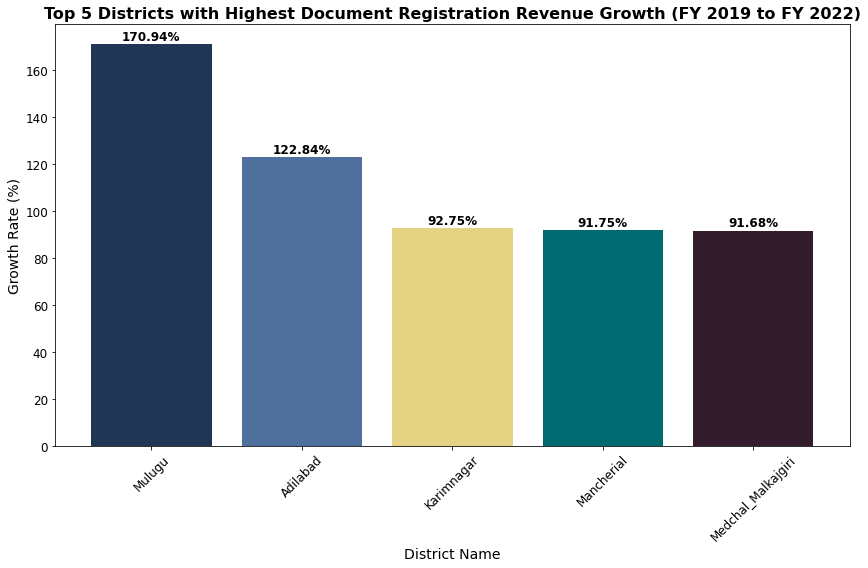

In [17]:
#Bar plot for top 5 districts with the highest revenue growth between FY 2019 and FY 2022
top_5_growth = revenue_growth.nlargest(5, 'growth_rate')

# Define the color codes
colors = ['#213555', '#4F709C', '#E5D283', '#016A70', '#331D2C', '#A78295', '#EFE1D1']

# Assuming the length of top_5_growth is 5, we'll use the first 5 colors
bar_colors = colors[:len(top_5_growth)]

# Sort values to have the highest on the left
top_5_growth = top_5_growth.sort_values(by='growth_rate', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(top_5_growth['district'], top_5_growth['growth_rate'], color=bar_colors)

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Top 5 Districts with Highest Document Registration Revenue Growth (FY 2019 to FY 2022)', fontsize=16, fontweight='bold')
plt.xlabel('District Name', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


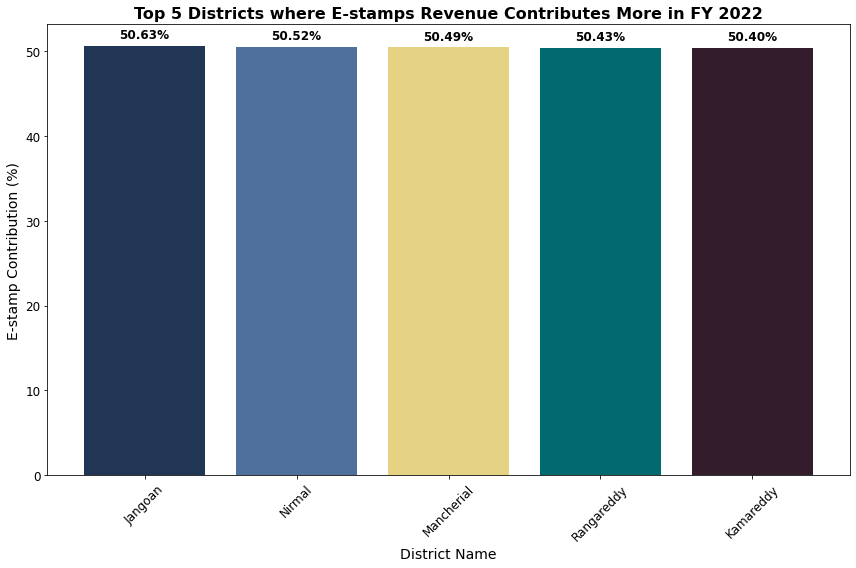

In [18]:
#Bar plot for top 5 districts where e-stamps revenue contributes more than documents in FY 2022
top_5_estamp_contrib = revenue_2022_district.nlargest(5, 'estamp_contribution')

# Define the color codes
colors = ['#213555', '#4F709C', '#E5D283', '#016A70', '#331D2C']

# Assuming the length of top_5_estamp_contrib is 5, we'll use the first 5 colors
bar_colors = colors[:len(top_5_estamp_contrib)]


plt.figure(figsize=(12, 8))
bars = plt.bar(top_5_estamp_contrib['district'], top_5_estamp_contrib['estamp_contribution'], color=bar_colors)

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Top 5 Districts where E-stamps Revenue Contributes More in FY 2022', fontsize=16, fontweight='bold')
plt.xlabel('District Name', fontsize=14)
plt.ylabel('E-stamp Contribution (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

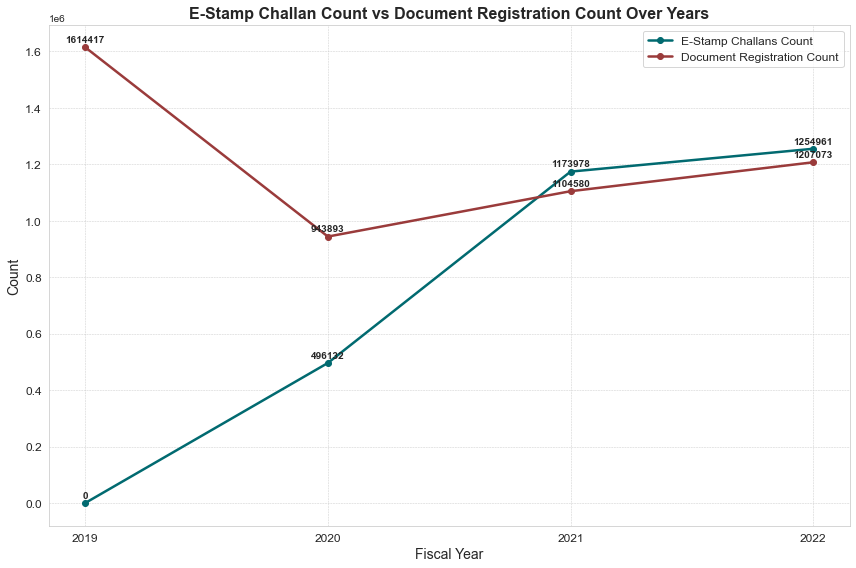

In [19]:
# Group data by fiscal_year
grouped_data = fact_with_date.groupby('fiscal_year')[['estamps_challans_cnt', 'documents_registered_cnt']].sum().reset_index()

# Use a seaborn style for a polished look
sns.set_style("whitegrid")

# Define the color codes
colors = ['#016A70', '#9A3B3B']

plt.figure(figsize=(12, 8))

# Plot lines and add labels for e-Stamp Challans Count
line1, = plt.plot(grouped_data['fiscal_year'].astype(int), grouped_data['estamps_challans_cnt'], marker='o', label='E-Stamp Challans Count', color=colors[0], linewidth=2.5)
for i, j in zip(grouped_data['fiscal_year'].astype(int), grouped_data['estamps_challans_cnt']):
    plt.annotate(f'{j:.0f}', (i, j), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, fontweight='bold')

# Plot lines and add labels for Document Registration Count
line2, = plt.plot(grouped_data['fiscal_year'].astype(int), grouped_data['documents_registered_cnt'], marker='o', label='Document Registration Count', color=colors[1], linewidth=2.5)
for i, j in zip(grouped_data['fiscal_year'].astype(int), grouped_data['documents_registered_cnt']):
    plt.annotate(f'{j:.0f}', (i, j), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, fontweight='bold')

plt.title('E-Stamp Challan Count vs Document Registration Count Over Years', fontsize=16, fontweight='bold')
plt.xlabel('Fiscal Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(grouped_data['fiscal_year'].astype(int), fontsize=12)  # Convert fiscal_year to integer for x-axis ticks
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

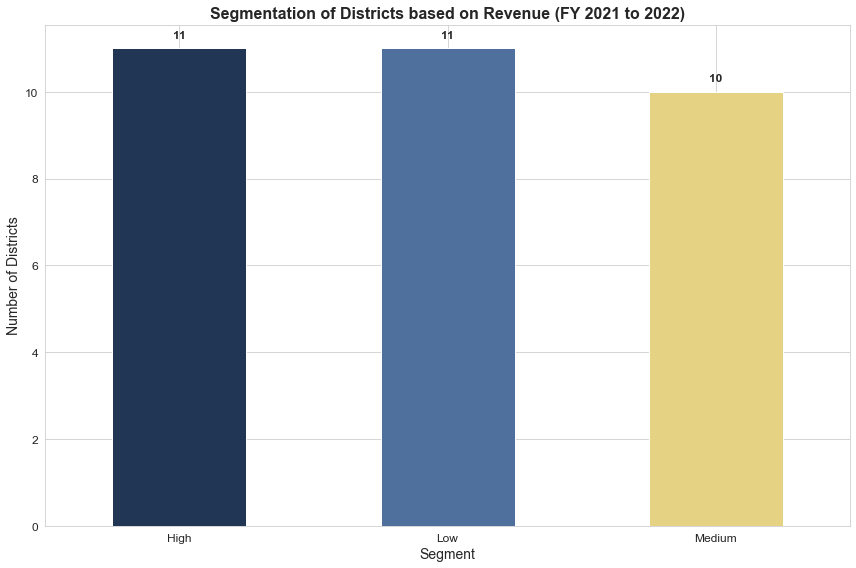

In [20]:
#Bar plot for segmentation of districts based on revenue during FY 2021 to 2022
segment_counts = revenue_2021_2022_district['segment'].value_counts().sort_index()

# Use a seaborn style for a polished look
sns.set_style("whitegrid")

# Define the color codes
colors = ['#213555', '#4F709C', '#E5D283', '#016A70', '#331D2C']

# Assuming the length of segment_counts is 3, we'll use the first 3 colors
bar_colors = colors[:len(segment_counts)]

plt.figure(figsize=(12, 8))
bars = segment_counts.plot(kind='bar', color=bar_colors)

# Add labels to bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{int(yval)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Segmentation of Districts based on Revenue (FY 2021 to 2022)', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Districts', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [22]:
# Merging with districts to get district names
revenue_2021_2022_district = revenue_2021_2022_district.merge(dim_districts, on='dist_code', how='left')

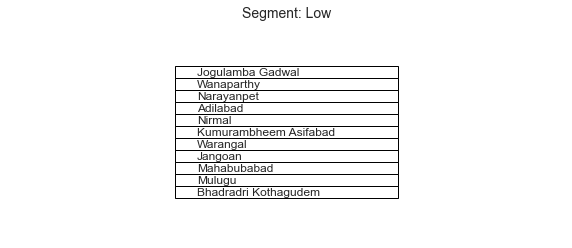

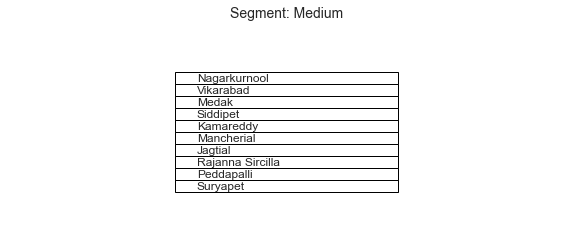

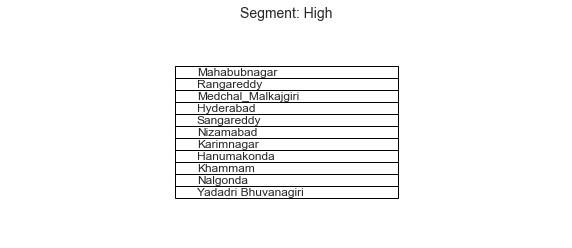

In [23]:
# Function to display table for each segment
def display_segment_table(segment_name):
    # Filter data for the given segment
    segment_data = revenue_2021_2022_district[revenue_2021_2022_district['segment'] == segment_name]
    
    # Create a figure with no axes
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('off')
    
    # Create the table and add it to the figure
    table_data = segment_data[['district']].values.tolist()
    table = ax.table(cellText=table_data, cellLoc='left', loc='center', colWidths=[0.4])
    
    # Set font size and title
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.title(f'Segment: {segment_name}', fontsize=14)
    plt.show()

# Display tables for each segment
for segment in ['Low', 'Medium', 'High']:
    display_segment_table(segment)

# Transportation

1. Investigate whether there is any correlation between vehicle sales and specific months or seasons in different districts. Are there any months or seasons that consistently show higher or lower sales rate, and if yes, what could be the driving factors? (Consider Fuel-Type category only)


2. How does the distribution of vehicles vary by vehicle class (MotorCycle, MotorCar, AutoRickshaw, Agriculture) across different districts? Are there any districts with a predominant preference for a specific vehicle class? Consider FY 2022 for analysis.


3. List down the top 3 and bottom 3 districts that have shown the highest and lowest vehicle sales growth during FY 2022 compared to FY 2021? (Consider and compare categories: Petrol, Diesel and Electric)

In [24]:
# Joining fact_transport with dim_date to get fiscal_year
fact_with_date = fact_transport.merge(dim_date[['month', 'fiscal_year']], on='month', how='left')

In [25]:
# Calculating total vehicle sales for each month across all districts (considering only fuel types)
fact_transport['total_sales'] = fact_transport[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']].sum(axis=1)

In [26]:
# Grouping by month to get monthly sales
monthly_sales = fact_transport.groupby('month')['total_sales'].sum().reset_index()

In [27]:
# Filtering data for FY 2022
fy_2022_transport = fact_with_date[fact_with_date['fiscal_year'] == 2022]

In [28]:
# Grouping by district to get distribution of each vehicle class
vehicle_class_distribution = fy_2022_transport.groupby('dist_code').agg({
    'vehicleClass_MotorCycle': 'sum',
    'vehicleClass_MotorCar': 'sum',
    'vehicleClass_AutoRickshaw': 'sum',
    'vehicleClass_Agriculture': 'sum'
}).reset_index()

In [29]:
# Filtering data for FY 2021 and FY 2022
fy_2021_transport = fact_with_date[fact_with_date['fiscal_year'] == 2021]

In [30]:
# Grouping by district to get total vehicle sales for FY 2021 and FY 2022 (considering Petrol, Diesel, and Electric)
sales_2021 = fy_2021_transport.groupby('dist_code').agg({
    'fuel_type_petrol': 'sum',
    'fuel_type_diesel': 'sum',
    'fuel_type_electric': 'sum'
}).reset_index()
sales_2021['total_sales_2021'] = sales_2021[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric']].sum(axis=1)

sales_2022 = fy_2022_transport.groupby('dist_code').agg({
    'fuel_type_petrol': 'sum',
    'fuel_type_diesel': 'sum',
    'fuel_type_electric': 'sum'
}).reset_index()
sales_2022['total_sales_2022'] = sales_2022[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric']].sum(axis=1)

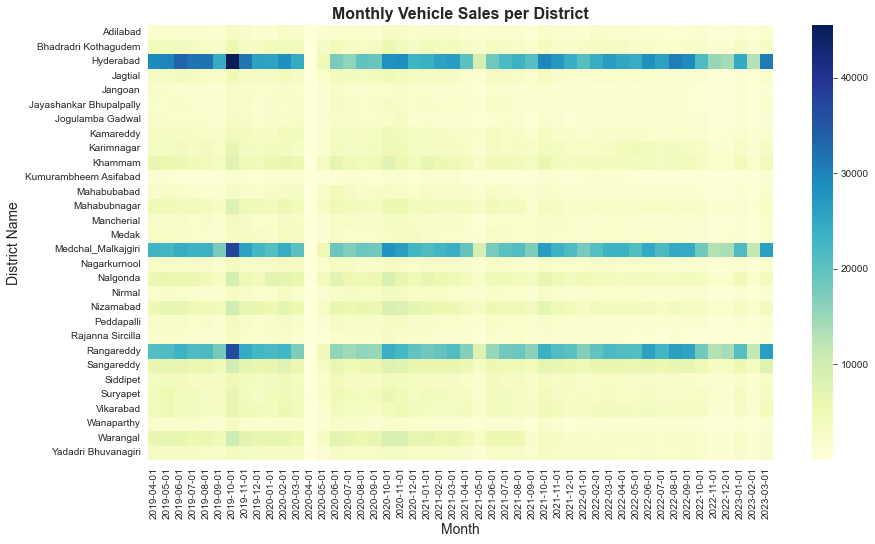

In [31]:
district_monthly_sales = fact_transport.groupby(['dist_code', 'month'])['total_sales'].sum().reset_index()
# Merging with district name
district_monthly_sales = district_monthly_sales.merge(dim_districts[['dist_code', 'district']], on='dist_code')
district_monthly_sales_pivot = district_monthly_sales.pivot("district", "month", "total_sales")

plt.figure(figsize=(14, 8))
sns.heatmap(district_monthly_sales_pivot, cmap="YlGnBu")
plt.title('Monthly Vehicle Sales per District', fontsize=16, fontweight='bold')
plt.ylabel('District Name', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.show()

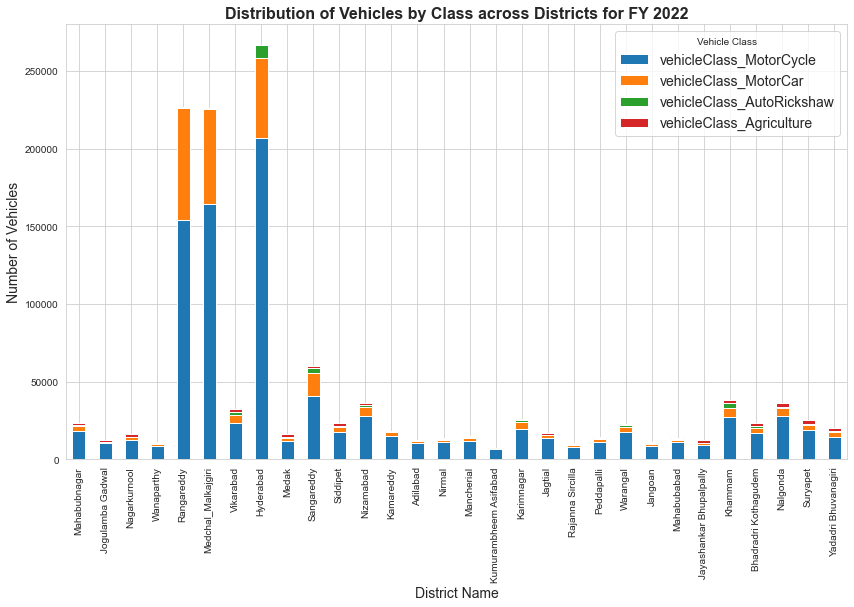

In [32]:
vehicle_class_distribution = vehicle_class_distribution.merge(dim_districts[['dist_code', 'district']], on='dist_code')
vehicle_class_distribution.set_index('district').drop(columns='dist_code').plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Vehicles by Class across Districts for FY 2022', fontsize=16, fontweight='bold')
plt.xlabel('District Name', fontsize=14)
plt.ylabel('Number of Vehicles', fontsize=14)
plt.legend(title='Vehicle Class', fontsize=14)
plt.show()

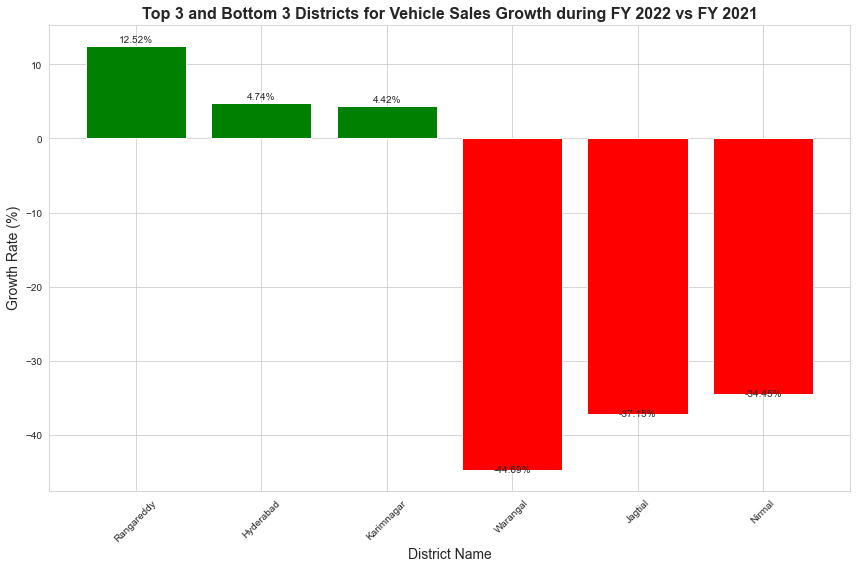

In [33]:
# Merge the sales data for 2021 and FY 2022 and calculate growth rate
merged_sales = sales_2021.merge(sales_2022, on='dist_code', how='inner')
merged_sales['growth_rate'] = ((merged_sales['total_sales_2022'] - merged_sales['total_sales_2021']) / merged_sales['total_sales_2021']) * 100

# Merge to get the district name
merged_sales = merged_sales.merge(dim_districts[['dist_code', 'district']], on='dist_code')

# Sort by growth rate and take top 3 and bottom 3
top_3 = merged_sales.nlargest(3, 'growth_rate')
bottom_3 = merged_sales.nsmallest(3, 'growth_rate')
top_bottom_3 = pd.concat([top_3, bottom_3])

# Plot with data labels
plt.figure(figsize=(12, 8))
colors = ['green' if growth > 0 else 'red' for growth in top_bottom_3['growth_rate']]
bars = plt.bar(top_bottom_3['district'], top_bottom_3['growth_rate'], color=colors)

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             yval + (0.02 * max(top_bottom_3['growth_rate'])) if yval > 0 else yval - (0.05 * max(top_bottom_3['growth_rate'])), 
             f'{yval:.2f}%', 
             ha='center', 
             va='bottom', 
             fontsize=10)

plt.title('Top 3 and Bottom 3 Districts for Vehicle Sales Growth during FY 2022 vs FY 2021', fontsize=16, fontweight='bold')
plt.xlabel('District Name', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ts-Ipass

1. List down the top 5 sectors that have witnessed the most significant investments in FY 2022.


2. List down the top 3 districts that have attracted the most significant sector investments during FY 2019 to 2022? What factors could have led to the substantial investments in these particular districts?


3. Is there any relationship between district investments, vehicles sales and stamps revenue within the same district between FY 2021 and 2022?


4. Are there any particular sectors that have shown substantial investment in multiple districts between FY 2021 and 2022?


5. Can we identify any seasonal patterns or cyclicality in the investment trends for specific sectors? Do certain sectors experience higher investments during particular months?

In [34]:
# Correcting the month format
fact_ipass['month'] = pd.to_datetime(fact_ipass['month']).dt.strftime('%Y-%m-%d')

In [35]:
# Merging the tables for investments data with date
investments_with_date_corrected = fact_ipass.merge(dim_date, on='month', how='left')

In [36]:
# Q1: Top 5 sectors in FY 2022
investments_fy_2022_corrected = investments_with_date_corrected[investments_with_date_corrected['fiscal_year'] == 2022]
sector_investments_fy_2022_corrected = investments_fy_2022_corrected.groupby('sector')['investment in cr'].sum().reset_index()
top_5_sectors_fy_2022_corrected = sector_investments_fy_2022_corrected.sort_values(by='investment in cr', ascending=False).head(5)

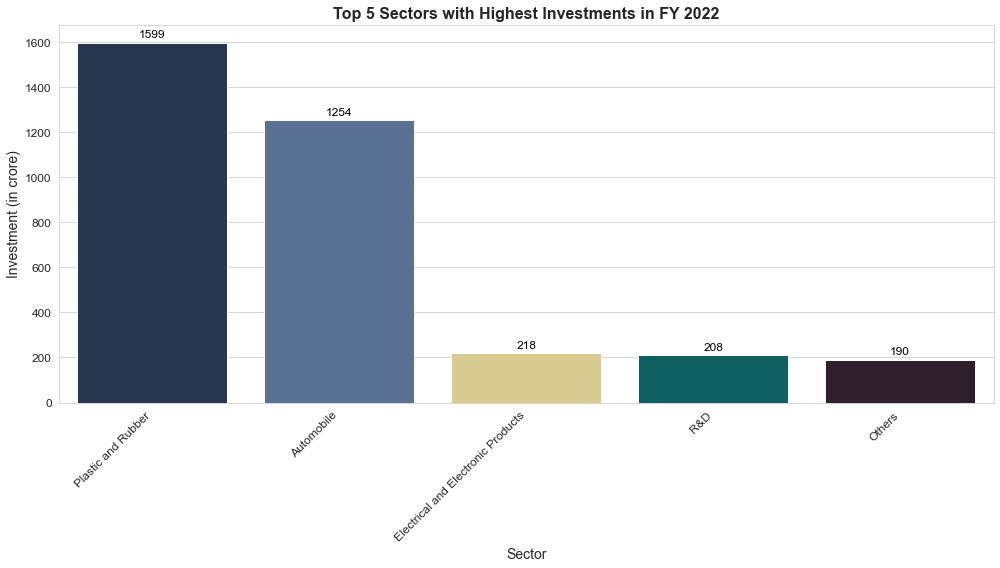

In [37]:
# Specified color codes
color_codes = ['#213555', '#4F709C', '#E5D283', '#016A70', '#331D2C', '#A78295', '#EFE1D1']

# Setting a style for better visuals
sns.set_style("whitegrid")

if not top_5_sectors_fy_2022_corrected.empty:
    plt.figure(figsize=(14, 8))
    
    # Using the color codes for the bars
    ax = sns.barplot(data=top_5_sectors_fy_2022_corrected, x='sector', y='investment in cr', palette=color_codes[:5])
    plt.title('Top 5 Sectors with Highest Investments in FY 2022', fontsize=16, fontweight='bold')
    plt.xlabel('Sector', fontsize=14)
    plt.ylabel('Investment (in crore)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Adding labels to the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 8), 
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

In [38]:
# Q2: Top 3 districts from FY 2019 to 2022
investments_fy_2019_2022 = investments_with_date_corrected[investments_with_date_corrected['fiscal_year'].isin([2019, 2020, 2021, 2022])]
district_investments_2019_2022_corrected = investments_fy_2019_2022.groupby('dist_code')['investment in cr'].sum().reset_index()
top_3_districts_2019_2022_corrected = district_investments_2019_2022_corrected.sort_values(by='investment in cr', ascending=False).head(3)
top_3_districts_names_corrected = top_3_districts_2019_2022_corrected.merge(dim_districts, on='dist_code', how='left')

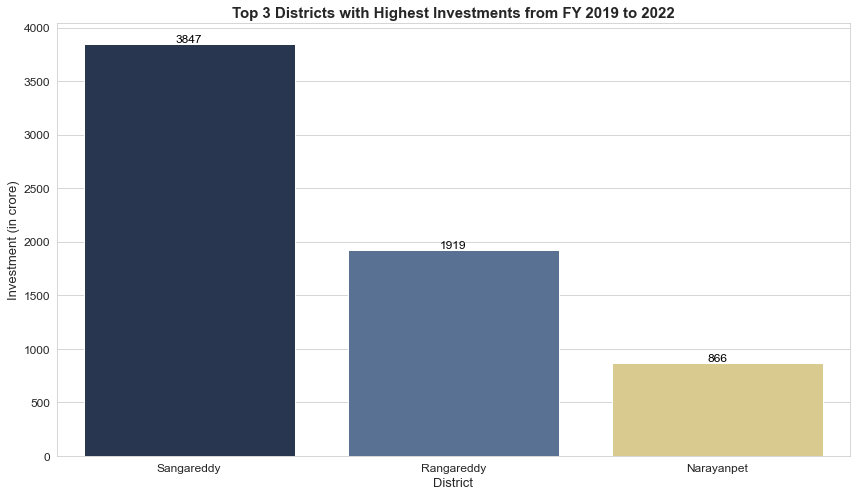

In [39]:
# Specified color codes
color_codes = ['#213555', '#4F709C', '#E5D283', '#016A70', '#331D2C', '#A78295', '#EFE1D1']

# Setting a style for better visuals
sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))

# Using only the first three colors for the top 3 districts
ax = sns.barplot(data=top_3_districts_names_corrected, x='district', y='investment in cr', palette=color_codes[:3])
plt.title('Top 3 Districts with Highest Investments from FY 2019 to 2022', fontsize=15, fontweight='bold')
plt.xlabel('District', fontsize=13)
plt.ylabel('Investment (in crore)', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

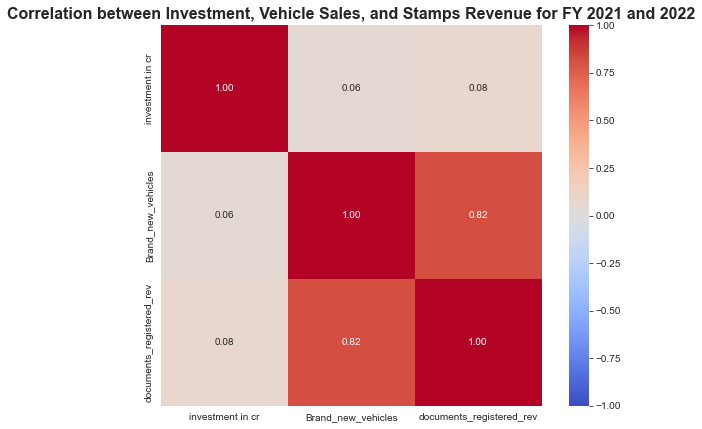

In [40]:
# Q3: Relationship between district investments, vehicle sales, and stamp revenue for FY 2021 and 2022

# Merging the datasets
merged_data = fact_ipass.merge(fact_transport, on='dist_code', how='inner')
merged_data = merged_data.merge(fact_stamps, on='dist_code', how='inner')
merged_data_with_date = merged_data.merge(dim_date, left_on='month', right_on='month', how='left')
merged_data_fy_2021_2022 = merged_data_with_date[merged_data_with_date['fiscal_year'].isin([2021, 2022])]

# Calculating correlation matrix for the relevant columns in the merged dataset
correlation_matrix = merged_data_fy_2021_2022[['investment in cr', 'Brand_new_vehicles', 'documents_registered_rev']].corr()

# Plotting the heatmap for correlation
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, fmt='.2f')
plt.title("Correlation between Investment, Vehicle Sales, and Stamps Revenue for FY 2021 and 2022" , fontsize=16, fontweight='bold')
plt.show()

In [41]:
# Q4: Sectors with investments in multiple districts for FY 2021 and 2022
investments_fy_2021_2022_corrected = investments_with_date_corrected[investments_with_date_corrected['fiscal_year'].isin([2021, 2022])]
sector_district_counts_corrected = investments_fy_2021_2022_corrected.groupby('sector')['dist_code'].nunique().reset_index()
sector_district_counts_sorted_corrected = sector_district_counts_corrected.sort_values(by='dist_code', ascending=False)

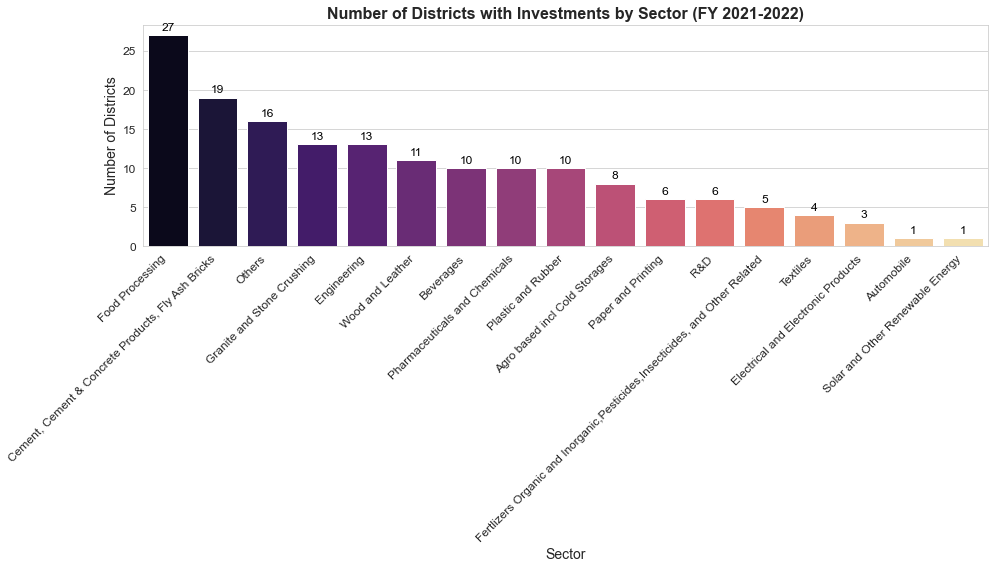

In [42]:
# Setting a style for better visuals
sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))

ax = sns.barplot(data=sector_district_counts_sorted_corrected, x='sector', y='dist_code', palette='magma')
plt.title('Number of Districts with Investments by Sector (FY 2021-2022)', fontsize=16, fontweight='bold')
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Number of Districts', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 8), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [43]:
# Q5: Seasonal patterns in investment trends
monthly_investments_by_sector_corrected = investments_with_date_corrected.groupby(['month', 'sector'])['investment in cr'].sum().reset_index()
monthly_investments_by_sector_sorted_corrected = monthly_investments_by_sector_corrected.sort_values(by='month')
top_sectors_corrected = monthly_investments_by_sector_sorted_corrected.groupby('sector')['investment in cr'].sum().nlargest(5).index.tolist()
filtered_data_corrected = monthly_investments_by_sector_sorted_corrected[monthly_investments_by_sector_sorted_corrected['sector'].isin(top_sectors_corrected)]

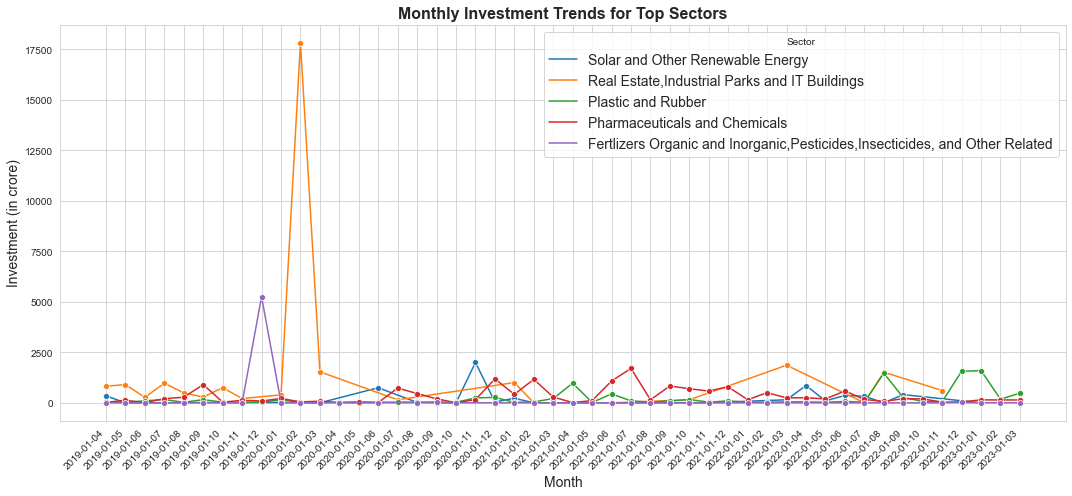

In [44]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=filtered_data_corrected, x='month', y='investment in cr', hue='sector', marker='o')
plt.title('Monthly Investment Trends for Top Sectors', fontsize=16, fontweight='bold')
plt.ylabel('Investment (in crore)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Sector', fontsize=14)
plt.show()


# Secondary Research

1. What are the top 5 districts to buy commercial properties in Telangana? Justify your answer.


2. What significant policies or initiatives were put into effect to enhance economic growth, investments, and employment in Telangana by the current government? Can we quantify the impact of these policies using available data?


3. Provide top 5 Insights & 5 recommendations to Telangana government for sustained growth in the next 5 years based on your analysis.

In [45]:
# Top districts based on revenue from document registration
district_revenue = fact_stamps.groupby('dist_code')['documents_registered_rev'].sum().reset_index()
district_revenue = district_revenue.merge(dim_districts, on='dist_code', how='left')
top_5_districts_revenue = district_revenue.sort_values(by='documents_registered_rev', ascending=False).head(5)

In [46]:
# Sector-wise investments analysis
sector_investments = fact_ipass.groupby('sector')[['investment in cr', 'number_of_employees']].sum().reset_index()
top_sectors_by_investment = sector_investments.sort_values(by='investment in cr', ascending=False).head(5)
top_sectors_by_employment = sector_investments.sort_values(by='number_of_employees', ascending=False).head(5)

In [47]:
# Monthly investments trend
monthly_investments = fact_ipass.groupby('month')['investment in cr'].sum().reset_index()
monthly_investments = monthly_investments.merge(dim_date, on='month', how='left')

In [48]:
print(top_5_districts_revenue)

   dist_code  documents_registered_rev            district
5       15_1              108198682809          Rangareddy
6       15_2               64071382839  Medchal_Malkajgiri
8       16_1               38396743983           Hyderabad
10      17_2               22024502771          Sangareddy
22      21_1                7927494100         Hanumakonda


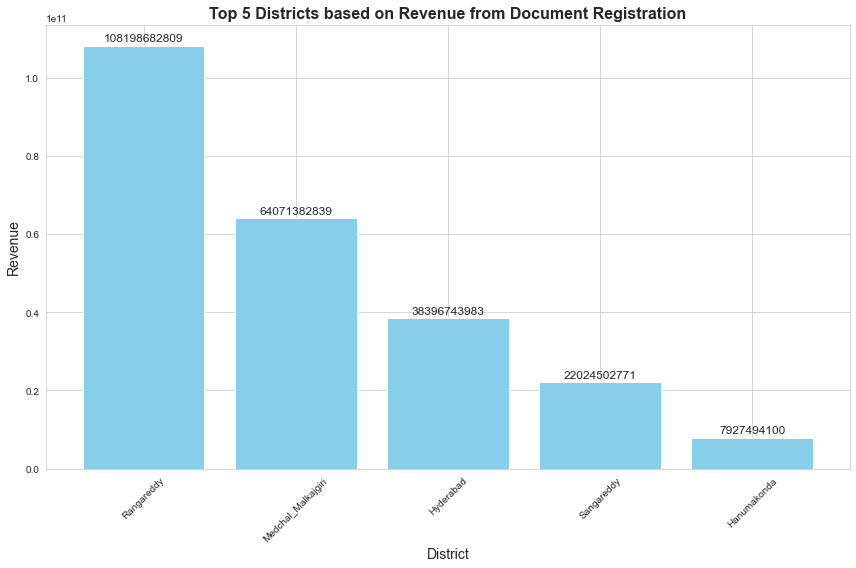

In [49]:
# Bar plot for Top 5 districts based on revenue from document registration
plt.figure(figsize=(12, 8))
bars = plt.bar(top_5_districts_revenue['district'], top_5_districts_revenue['documents_registered_rev'], color='skyblue')
plt.title('Top 5 Districts based on Revenue from Document Registration', fontsize=16, fontweight='bold')
plt.xlabel('District', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 1 - 0.4, 
             bar.get_height() + 0.01 * max(top_5_districts_revenue['documents_registered_rev']),
             round(bar.get_height(), 2), 
             ha='center', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
print(top_sectors_by_investment)

                                               sector  investment in cr  \
15      Real Estate,Industrial Parks and IT Buildings        29778.1741   
12                      Pharmaceuticals and Chemicals        15858.0561   
13                                 Plastic and Rubber         9649.7846   
16                   Solar and Other Renewable Energy         5639.7032   
6   Fertlizers Organic and Inorganic,Pesticides,In...         5418.3977   

    number_of_employees  
15               352558  
12                73841  
13                23301  
16                 3926  
6                  2325  


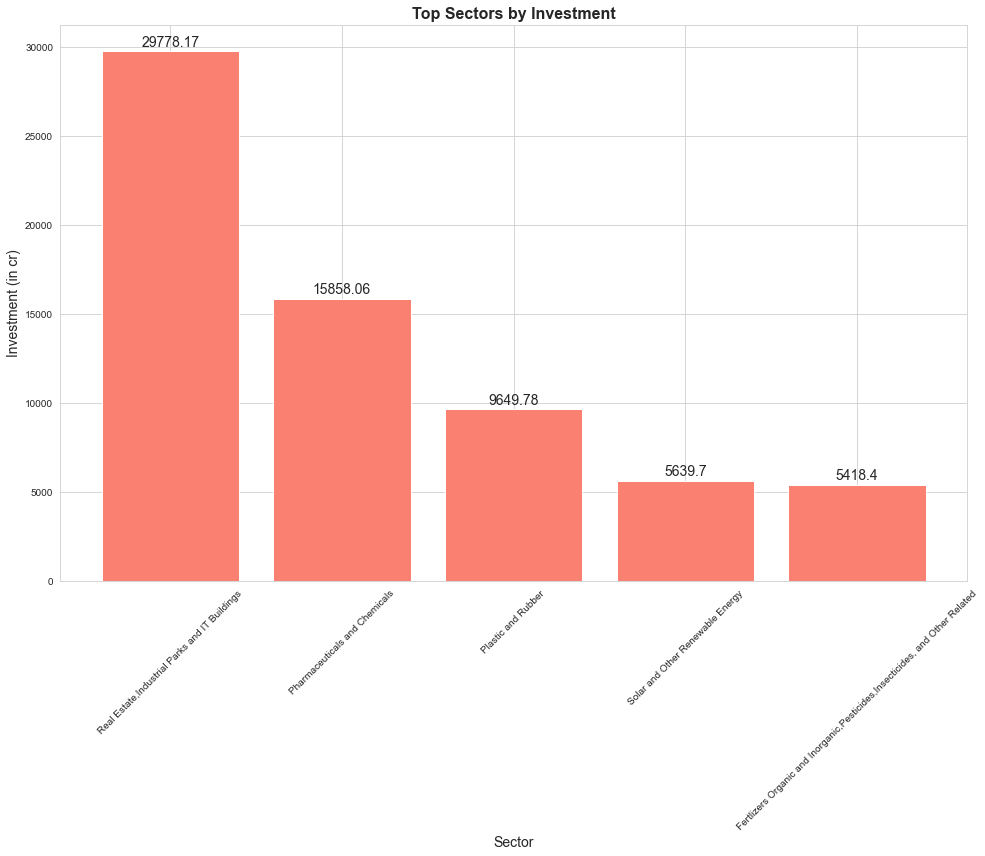

In [51]:
# Bar plot for Top sectors by investment
plt.figure(figsize=(14, 12))
bars = plt.bar(top_sectors_by_investment['sector'], top_sectors_by_investment['investment in cr'], color='salmon')
plt.title('Top Sectors by Investment', fontsize=16, fontweight='bold')
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Investment (in cr)', fontsize=14)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 1 - 0.4, 
             bar.get_height() + 0.01 * max(top_sectors_by_investment['investment in cr']),
             round(bar.get_height(), 2), 
             ha='center', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
print(top_sectors_by_employment)

                                           sector  investment in cr  \
15  Real Estate,Industrial Parks and IT Buildings        29778.1741   
12                  Pharmaceuticals and Chemicals        15858.0561   
5                                     Engineering         5024.6131   
7                                 Food Processing         4115.9122   
13                             Plastic and Rubber         9649.7846   

    number_of_employees  
15               352558  
12                73841  
5                 43093  
7                 40548  
13                23301  


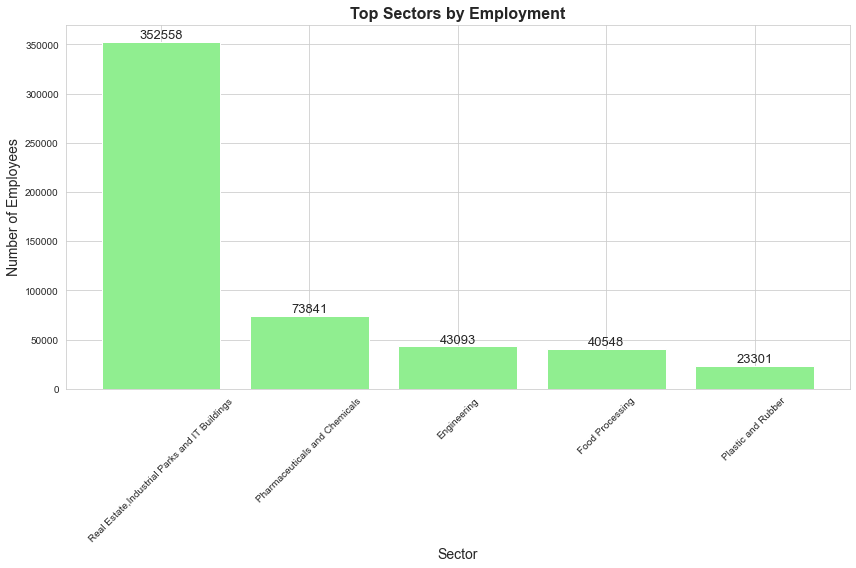

In [53]:
# Bar plot for Top sectors by employment
plt.figure(figsize=(12, 8))
bars = plt.bar(top_sectors_by_employment['sector'], top_sectors_by_employment['number_of_employees'], color='lightgreen')
plt.title('Top Sectors by Employment', fontsize=16, fontweight='bold')
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 1 - 0.4, 
             bar.get_height() + 0.01 * max(top_sectors_by_employment['number_of_employees']),
             round(bar.get_height(), 2), 
             ha='center', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

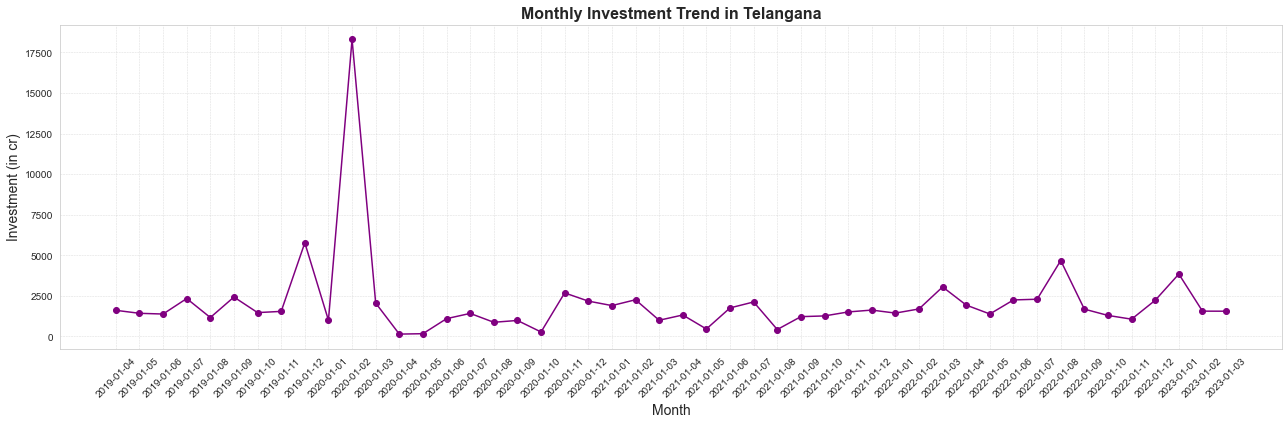

In [54]:
# Line plot for Monthly investments trend
plt.figure(figsize=(18, 6))
plt.plot(monthly_investments['month'], monthly_investments['investment in cr'], marker='o', linestyle='-', color='purple')
plt.title('Monthly Investment Trend in Telangana', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Investment (in cr)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# Other Research

1. Analyzing the trend of electric vehicle sales in Telangana

2. Calculating the correlation between investments and employment generation across sectors

3. Calculating the top months based on document registration revenue

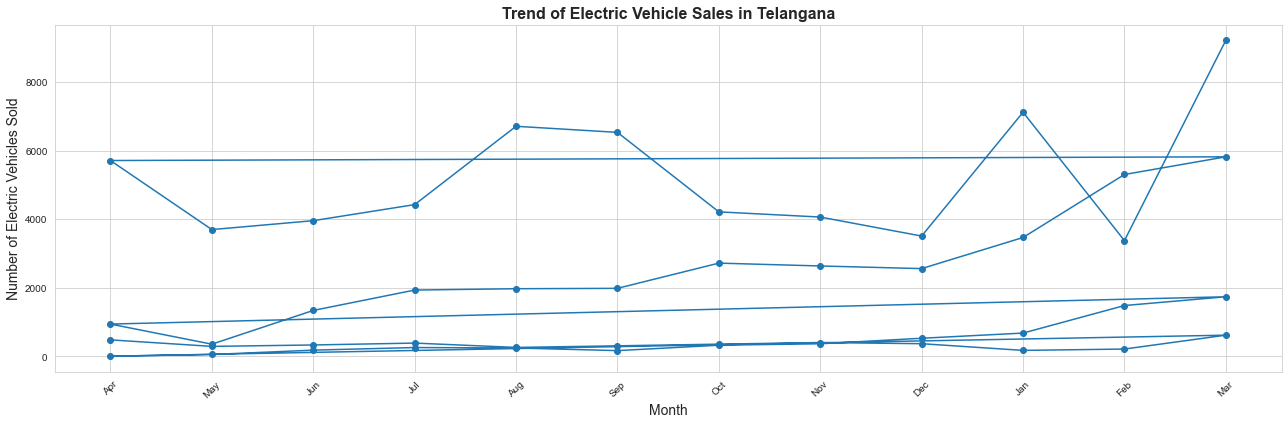

In [55]:
# Analyzing the trend of electric vehicle sales in Telangana
electric_vehicle_monthly_sales = fact_transport.groupby('month')['fuel_type_electric'].sum().reset_index()
electric_vehicle_monthly_sales = electric_vehicle_monthly_sales.merge(dim_date, on='month', how='left')
plt.figure(figsize=(18, 6))
plt.plot(electric_vehicle_monthly_sales['Mmm'], electric_vehicle_monthly_sales['fuel_type_electric'], marker='o', linestyle='-')
plt.title('Trend of Electric Vehicle Sales in Telangana', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Electric Vehicles Sold', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Calculating the correlation between investments and employment generation across sectors
sector_investments = fact_ipass.groupby('sector')[['investment in cr', 'number_of_employees']].sum().reset_index()
correlation_coefficient = sector_investments['investment in cr'].corr(sector_investments['number_of_employees'])
print("Correlation between investments and employment generation:", correlation_coefficient)

Correlation between investments and employment generation: 0.9192932695470518


In [57]:
# Calculating the top months based on document registration revenue
monthly_document_registration = fact_stamps.groupby('month')['documents_registered_rev'].sum().reset_index()
monthly_document_registration = monthly_document_registration.merge(dim_date, on='month', how='left')
top_months_for_document_registration = monthly_document_registration.sort_values(by='documents_registered_rev', ascending=False).head(5)
print(top_months_for_document_registration[['Mmm', 'documents_registered_rev']])

    Mmm  documents_registered_rev
46  Mar               10491968882
32  Jan               10472928077
35  Apr               10031873372
31  Dec                9992278674
34  Mar                9805934795


<center><b><span style="font-size: 24px;">Insights</span></b></center>

1. Real Estate & IT Dominance: The sector "Real Estate, Industrial Parks and IT Buildings" has seen the highest investments and also offers the most employment, making it a crucial sector for the state.


2. Pharmaceuticals & Chemicals: This sector ranks second in both investments and employment, indicating its significance in the state's industrial landscape.


3. Diverse Economic Landscape: Sectors like "Plastic and Rubber," "Solar and Other Renewable Energy," and "Engineering" have attracted notable investments, showing the diverse economic activities in the state.


4. Steady Economic Growth: The upward trend in monthly investments suggests a steadily growing economy in Telangana.



5. Vehicle Sales & Stamps Revenue Correlation: The correlation between vehicle sales and stamp revenues in districts indicates the interconnectedness of economic growth and commercial activities.


<center><span style="font-size: 24px;">Thank You!</span></center>